## Imports:

In [1]:
import pandas as pnd
import numpy as nmp
import math

import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from scipy.stats import pointbiserialr
from pycaret.classification import *

## Create dataframe from the dataset's CSV

In [2]:
df = pnd.read_csv("dataset.csv")

df.head()

,Id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1001,NaN,management,married,tertiary,no,2143.0,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,1002,NaN,NaN,single,secondary,no,29.0,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,1003,NaN,entrepreneur,married,secondary,no,2.0,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,1004,47.0,blue-collar,married,unknown,no,1506.0,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,1005,33.0,unknown,single,unknown,no,1.0,no,no,unknown,5,may,198,1,-1,0,unknown,no


## Data Preprocessing

### Pre analysis
The pre anaysis must be done in the first place, so that we can identify outliers.

TODO: Should we fix the age feature (switch the ones where the age is -1 with the mean?)

In [3]:
df.describe()

,Id,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45199.000000,45208.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,23606.000000,40.933627,1362.346620,15.806419,258.163080,2.763841,40.197828,0.580323
std,13051.435847,10.623149,3044.852387,8.322476,257.527812,3.098021,100.128746,2.303441
min,1001.000000,-1.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,12303.500000,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,23606.000000,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,34908.500000,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,46211.000000,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [4]:
df.isna().any()

Id           False
age           True
job           True
marital      False
education    False
default      False
balance       True
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
y            False
dtype: bool

### Filtering Outliers
By making the previous checks, we know that:
 - The ID column is quite useless for our study, and therefore should be excluded;
 - There are rows where there is no age, job or balance value - these rows should be pruned. This can be done without impacting our dataset too much, since there are only about 15 rows that are dopped after this;
 - Besides the previously pruned, we should also prune two other columns: the "poutcome" column and the "contact" column, since both of them have "unknown" as all their values;
 - We also should be removing all duplicate rows, since a client should have only one and only one proccess;

In [5]:
df = df.drop(["Id", "poutcome", "contact"], axis="columns")
df = df.dropna()
df = df.drop_duplicates()

Now, we should check the numerical features' plots in order to find more outliers.

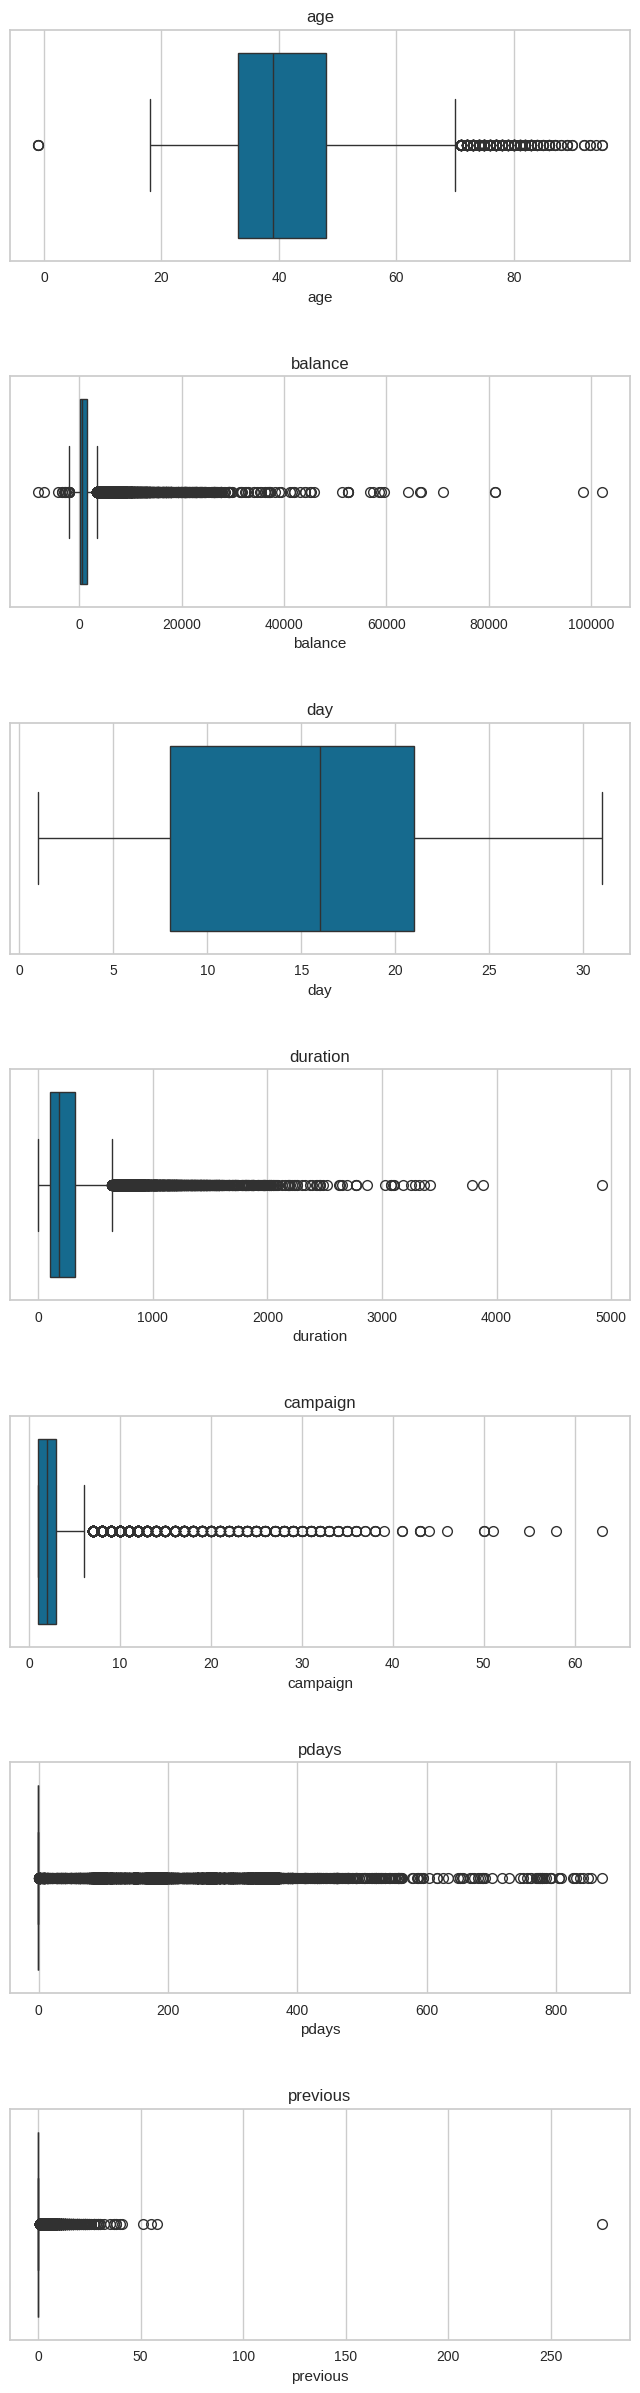

In [6]:
cols_num = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(8,30))
fig.subplots_adjust(hspace=0.5)

for i, col in enumerate(cols_num):
    sb.boxplot(x=col, data=df, ax=ax[i]) # "boxplot" can allow us to see the outliers points
    ax[i].set_title(col)


As we can see, there are still a few outliers we can filter, namely on the 'age', 'duration' and the 'previous' features.

In [7]:
df = df[df["age"] >= 18]
df = df[df["duration"] < 4000]
df = df[df["previous"] < 200]

In [8]:
df.shape

(45192, 15)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45192 entries, 3 to 45210
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        45192 non-null  float64
 1   job        45192 non-null  object 
 2   marital    45192 non-null  object 
 3   education  45192 non-null  object 
 4   default    45192 non-null  object 
 5   balance    45192 non-null  float64
 6   housing    45192 non-null  object 
 7   loan       45192 non-null  object 
 8   day        45192 non-null  int64  
 9   month      45192 non-null  object 
 10  duration   45192 non-null  int64  
 11  campaign   45192 non-null  int64  
 12  pdays      45192 non-null  int64  
 13  previous   45192 non-null  int64  
 14  y          45192 non-null  object 
dtypes: float64(2), int64(5), object(8)
memory usage: 5.5+ MB


### Encoding variables

Now, let's check which variables are objects and which are floats and encode the objects so that we can use them with our models. 

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45192 entries, 3 to 45210
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        45192 non-null  float64
 1   job        45192 non-null  object 
 2   marital    45192 non-null  object 
 3   education  45192 non-null  object 
 4   default    45192 non-null  object 
 5   balance    45192 non-null  float64
 6   housing    45192 non-null  object 
 7   loan       45192 non-null  object 
 8   day        45192 non-null  int64  
 9   month      45192 non-null  object 
 10  duration   45192 non-null  int64  
 11  campaign   45192 non-null  int64  
 12  pdays      45192 non-null  int64  
 13  previous   45192 non-null  int64  
 14  y          45192 non-null  object 
dtypes: float64(2), int64(5), object(8)
memory usage: 5.5+ MB


In this section, we will enconde all the object type variables that we got ubove.

In [11]:
encoder = LabelEncoder()

df['y'] = encoder.fit_transform(df['y'])
df['job'] = encoder.fit_transform(df['job'])
df['marital'] = encoder.fit_transform(df['marital'])
df['education'] = encoder.fit_transform(df['education'])
df['default'] = encoder.fit_transform(df['default'])
df['housing'] = encoder.fit_transform(df['housing'])
df['loan'] = encoder.fit_transform(df['loan'])
df['month'] = encoder.fit_transform(df['month'])

df.head()

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,y
3,47.0,1,1,3,0,1506.0,1,0,5,8,92,1,-1,0,0
4,33.0,11,2,3,0,1.0,0,0,5,8,198,1,-1,0,0
5,35.0,4,1,2,0,231.0,1,0,5,8,139,1,-1,0,0
6,28.0,4,2,2,0,447.0,1,1,5,8,217,1,-1,0,0
10,41.0,0,0,1,0,270.0,1,0,5,8,222,1,-1,0,0


### Data correlation
Here, we will examine how the features are numerically correlated with the target variable.


In [12]:
list_corr = df.corr()[['y']]

As the correlations calculated above are Pearson correlations, we will adjust the values for the numerical and categorical variables using the point biserial correlation.

In [13]:
# Numerical features correlation with the target variable   
list_corr['y']['age'] = pointbiserialr(df['age'], df['y'])[0]
list_corr['y']['balance'] = pointbiserialr(df['balance'], df['y'])[0]
list_corr['y']['day'] = pointbiserialr(df['day'], df['y'])[0]
list_corr['y']['duration'] = pointbiserialr(df['duration'], df['y'])[0]
list_corr['y']['campaign'] = pointbiserialr(df['campaign'], df['y'])[0]
list_corr['y']['pdays'] = pointbiserialr(df['pdays'], df['y'])[0]
list_corr['y']['previous'] = pointbiserialr(df['previous'], df['y'])[0]

# Categorical features correlation with the target variable
list_corr['y']['job'] = pointbiserialr(df['job'], df['y'])[0]
list_corr['y']['marital'] = pointbiserialr(df['marital'], df['y'])[0]
list_corr['y']['education'] = pointbiserialr(df['education'], df['y'])[0]
list_corr['y']['month'] = pointbiserialr(df['month'], df['y'])[0]


<Axes: >

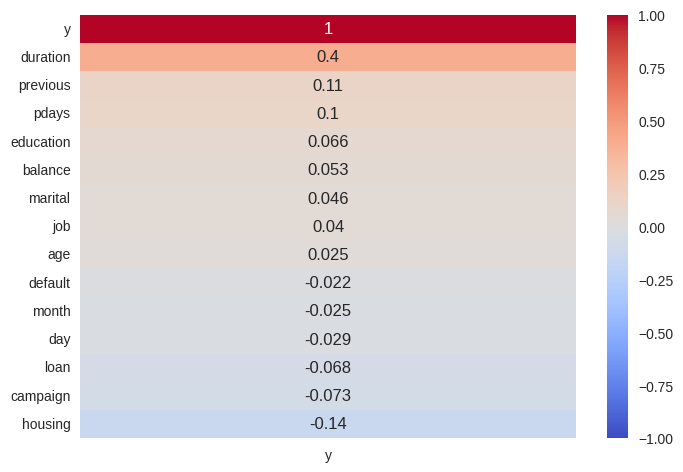

In [14]:
sb.heatmap(list_corr.sort_values(by='y', ascending=False), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

This analysis revealed that a large portion of the features are not correlated with the target, which is not good for our models.

### Data Sampling

Now that we encoded our object variables, we can move forward. 

By checking the amount of positives and negatives on our target variable, we can see that there's a huge difference between the number of clients that did and didn't subscribe to the product. 

In order to make our data more viable, we have two options:
 - Sample the variable with the highest number of rows;
 - Duplicate the variable with the least number of rows.

In [15]:
print(df['y'].value_counts())

df_majority = df[df['y'] == 0]
df_minority = df[df['y'] == 1]

sample_size = int(len(df_majority)/4)
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=sample_size,     # match number in minority class
                                   random_state=42)  # reproducible results

# Combine minority class with downsampled majority class
df_balanced = pnd.concat([df_minority, df_majority_downsampled])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the new class distribution
print(df_balanced['y'].value_counts())

y
0    39906
1     5286
Name: count, dtype: int64
y
0    9976
1    5286
Name: count, dtype: int64


### Data Analysis

After the previous steps, that envisioned to clean our dataset, we can now analyse our data and compare how the feature correlate with each other and how they're distributed.

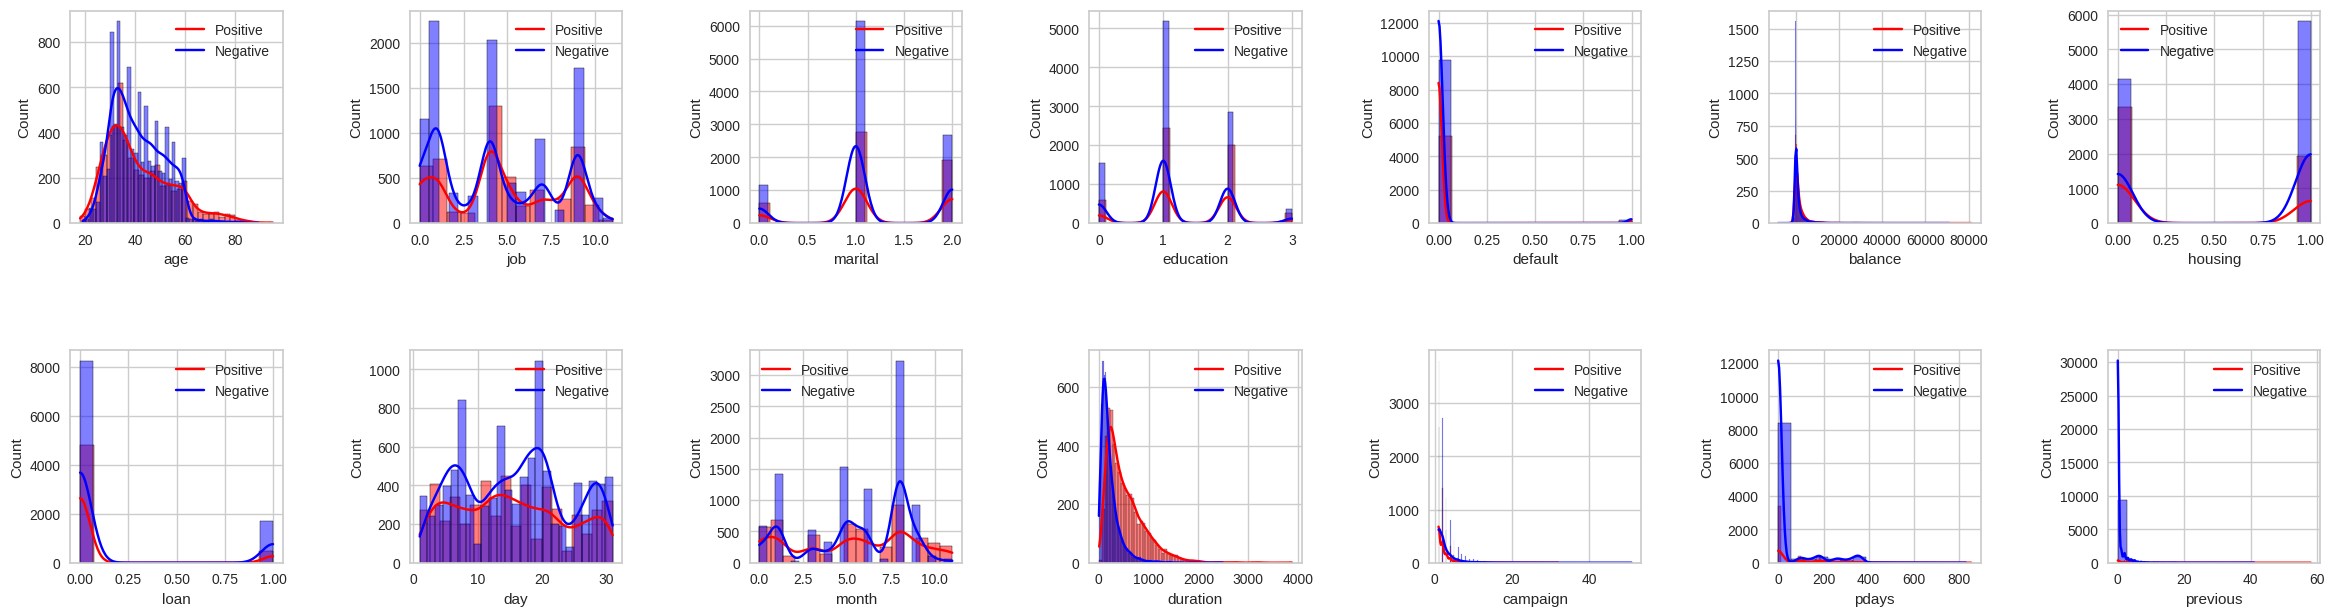

In [16]:
plt.figure(figsize=(25,25))
plt.subplots_adjust(left=0.2,bottom=0.2,right=1.1,top=1.1,wspace=0.6,hspace=0.6)

posdf = df_balanced[df_balanced['y']==1].drop(['y'],axis=1)
negdf = df_balanced[df_balanced['y']==0].drop(['y'],axis=1)

cols = list(posdf.columns)
for i, col in enumerate(cols):
    plt.subplot(int(len(cols)/2),int(len(cols)/2),i+1)
    sb.histplot(data=posdf[col], color='red', label = 'Positive', kde=True)
    sb.histplot(data=negdf[col], color='blue', label = 'Negative', kde=True)
    _,axes = plt.gca().get_legend_handles_labels()
    plt.legend(axes,prop={'size': 10})

plt.show()

Now that we have correctly displayed our data in plots, lets encode the object variables so that we can create our heatmap.

In [17]:
df_balanced['job'] = encoder.fit_transform(df_balanced['job'])
df_balanced['marital'] = encoder.fit_transform(df_balanced['marital'])
df_balanced['education'] = encoder.fit_transform(df_balanced['education'])
df_balanced['default'] = encoder.fit_transform(df_balanced['default'])
df_balanced['housing'] = encoder.fit_transform(df_balanced['housing'])
df_balanced['loan'] = encoder.fit_transform(df_balanced['loan'])
df_balanced['month'] = encoder.fit_transform(df_balanced['month'])

<Axes: >

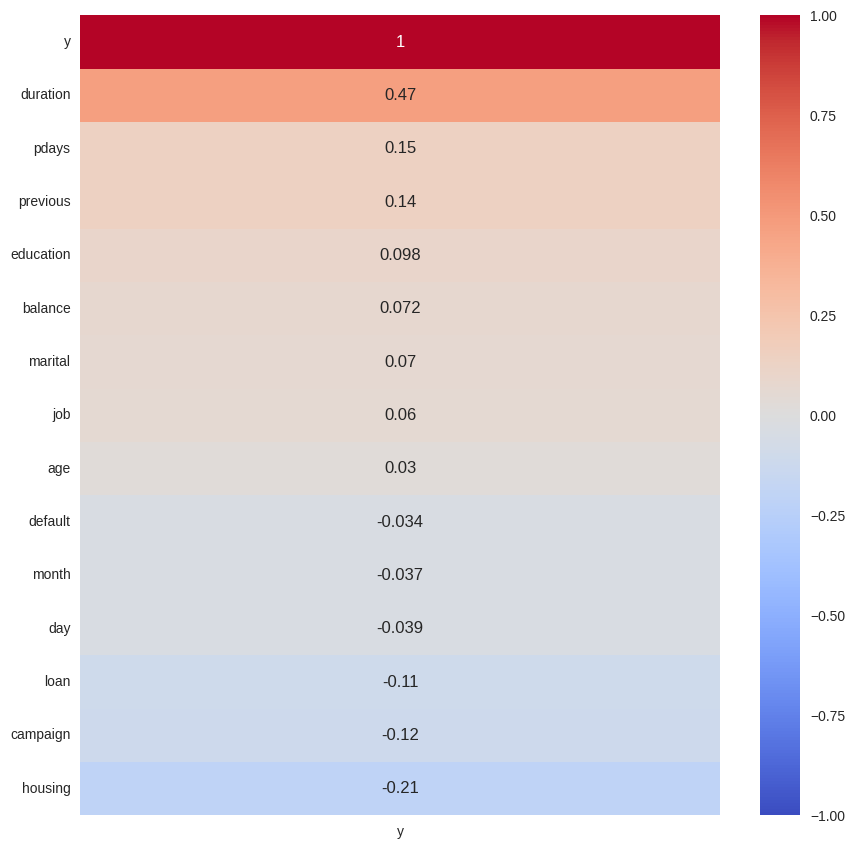

In [18]:
cols = list(df_balanced.columns)

plt.figure(figsize=(10,10))
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

corr = df_balanced.corr()[['y']].sort_values(by='y', ascending=False)
sb.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

### Split the dataset
Now that all data has been preprocessed, we need to separate the features and the labels.

In [19]:
features = df_balanced.drop(['y'], axis=1)
target = df_balanced['y']

nmp.unique(target, return_counts=True)


(array([0, 1]), array([9976, 5286]))

We will now proceed to create the training and testing sets. Given that the dataset is significantly unbalanced — with 9,976 samples labeled 'no' and 5,286 labeled 'yes' — and considering our dataset's large size, we will not use all the 'no' samples. This approach will help maintain balance in the training set.

In [20]:
x_train, x_test, y_train, y_test = train_test_split(features,target,test_size=0.2, random_state=42)
nmp.unique(y_train, return_counts=True), nmp.unique(y_test, return_counts=True)

((array([0, 1]), array([7989, 4220])), (array([0, 1]), array([1987, 1066])))

In [21]:
# Eliminate excess the majority class
x_train_majority, y_train_majority = resample(x_train[y_train==0], y_train[y_train==0], n_samples=4220, random_state=42)
x_train_minority, y_train_minority = resample(x_train[y_train==1], y_train[y_train==1])

x_train = nmp.concatenate((x_train_majority, x_train_minority))
y_train = nmp.concatenate((y_train_majority, y_train_minority))

nmp.unique(y_train, return_counts=True), nmp.unique(y_test, return_counts=True)

((array([0, 1]), array([4220, 4220])), (array([0, 1]), array([1987, 1066])))

## Model Training

Now that our dataset looks ready to go, lets start our model training phase.

The algorithms we're looking to implement are:
- Decision Tree;
- K-Nearest Neighbors;
- Support Vector Machine;
- Neural Network;



In [22]:
classification = setup(data = df_balanced, train_size=0.8, target = 'y', normalize=True, transformation=True)

best = compare_models()

results = pull()
results

,Description,Value
0,Session id,8436
1,Target,y
2,Target type,Binary
3,Original data shape,"(15262, 15)"
4,Transformed data shape,"(15262, 15)"
5,Transformed train set shape,"(12209, 15)"
6,Transformed test set shape,"(3053, 15)"
7,Numeric features,14
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8558,0.9243,0.8049,0.7848,0.7945,0.6836,0.6839,128.4370
rf,Random Forest Classifier,0.8456,0.9147,0.7808,0.7753,0.7779,0.6596,0.6598,0.2200
gbc,Gradient Boosting Classifier,0.8391,0.9121,0.7557,0.7745,0.7648,0.6425,0.6428,0.2410
et,Extra Trees Classifier,0.8327,0.9076,0.7196,0.7806,0.7486,0.6236,0.6249,0.2140
ada,Ada Boost Classifier,0.8173,0.8940,0.6801,0.7661,0.7203,0.5854,0.5878,0.1420
lr,Logistic Regression,0.8025,0.8719,0.6668,0.7385,0.7006,0.5538,0.5557,0.3680
lda,Linear Discriminant Analysis,0.8011,0.8712,0.6668,0.7352,0.6991,0.5511,0.5528,0.0490
ridge,Ridge Classifier,0.8000,0.8712,0.6538,0.7395,0.6937,0.5461,0.5486,0.0410
knn,K Neighbors Classifier,0.7881,0.8388,0.6309,0.7225,0.6735,0.5177,0.5204,0.2490
svm,SVM - Linear Kernel,0.7856,0.8586,0.6510,0.7088,0.6768,0.5172,0.5197,0.0510


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8558,0.9243,0.8049,0.7848,0.7945,0.6836,0.6839,128.437
rf,Random Forest Classifier,0.8456,0.9147,0.7808,0.7753,0.7779,0.6596,0.6598,0.220
gbc,Gradient Boosting Classifier,0.8391,0.9121,0.7557,0.7745,0.7648,0.6425,0.6428,0.241
et,Extra Trees Classifier,0.8327,0.9076,0.7196,0.7806,0.7486,0.6236,0.6249,0.214
ada,Ada Boost Classifier,0.8173,0.8940,0.6801,0.7661,0.7203,0.5854,0.5878,0.142
lr,Logistic Regression,0.8025,0.8719,0.6668,0.7385,0.7006,0.5538,0.5557,0.368
lda,Linear Discriminant Analysis,0.8011,0.8712,0.6668,0.7352,0.6991,0.5511,0.5528,0.049
ridge,Ridge Classifier,0.8000,0.8712,0.6538,0.7395,0.6937,0.5461,0.5486,0.041
knn,K Neighbors Classifier,0.7881,0.8388,0.6309,0.7225,0.6735,0.5177,0.5204,0.249
svm,SVM - Linear Kernel,0.7856,0.8586,0.6510,0.7088,0.6768,0.5172,0.5197,0.051
